# Off-by-one error

This notebook is a quick analysis (with commented code!) of deep learnings ability to find off-by-one decimal errors in an income distribution. The income distribution will be simulated with a log-normal distribution.

## Libraries

In [1]:
import tensorflow as tf
import tensorflow.contrib.eager as tfe
import tensorflow_probability as tfp
from tensorflow import keras

tf.enable_eager_execution()

print("TensorFlow version: {}".format(tf.VERSION))
print("Eager execution: {}".format(tf.executing_eagerly()))

/home/badbayesian/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow version: 1.10.1
Eager execution: True


In [2]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

## Boilerplate (Fake Data Creation)

In [3]:
def off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=0.1, data=None, ordinal_error=True):
    """Create log-normal data set with off-by-one decimal error."""

    if data is None:
        true_value = np.random.lognormal(mu, sigma, n)
    else:
        true_value = data
        n = len(true_value)
    true_value = [round(i, 5) for i in true_value]
    if ordinal_error:
        error_types = [1,2,3] #-1 for left error, 1 for right error, 0 for no error.
        # tensorflow is doing a one-hot encoding, although on future iterations we would like to keep the
        # ordinal (not cardinal) nature of the error.
        error = np.random.choice(error_types, n, p=[error_rate/2, error_rate/2, 1-error_rate])
    else:
        error = np.random.binomial(1, error_rate, n)
    
    observed = np.zeros(n)
    for i in range(n):
        if error[i] == 1:
            observed[i] = true_value[i]/10
        elif error[i] == 2:
            observed[i] = true_value[i]*10
        else:
            observed[i] = true_value[i]
    data = {"error" : error, "observed" : observed, "true_value" : true_value}
    return pd.DataFrame(data=data)

## Introduction

As the amount of error increases, the observed and true value distributions become more separable. Note that with this log-normal distribution, the observed distribution becomes bimodal. However, we would expect 

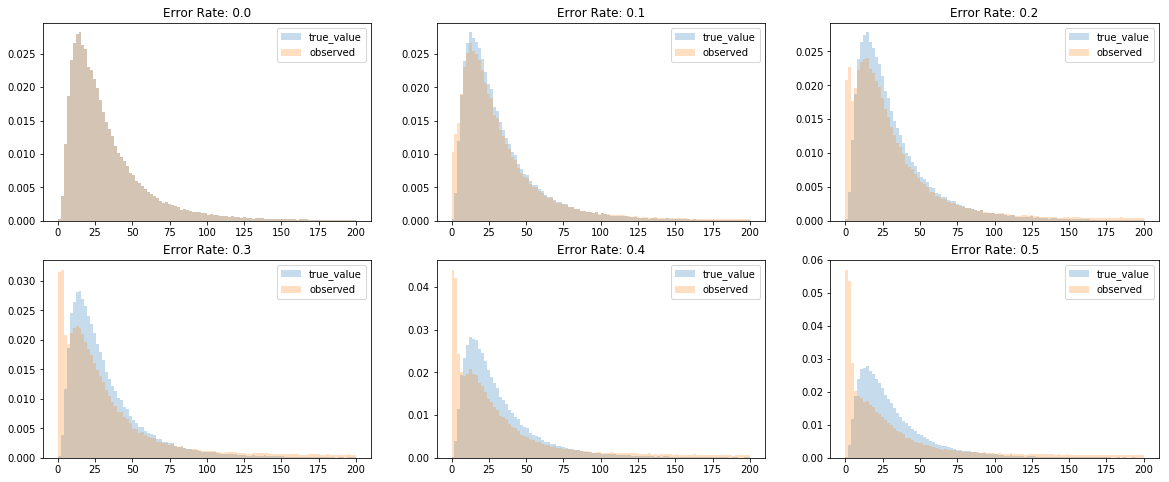

In [4]:
df = [off_by_one(mu=np.log(25), sigma=np.log(10)/3, n=int(1e5), error_rate=i) for i in np.arange(0, .6, 0.1)]

fig, axs = plt.subplots(2,3, figsize=(20,8), facecolor='w', edgecolor='k')

for ax, i in zip(axs.ravel(), range(0,6)):
        ax.hist(df[i]["true_value"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.hist(df[i]["observed"], bins=100, alpha=0.25, range=[0,200], density=True)
        ax.legend()
        ax.set_title("Error Rate: " + str(round(i*0.1, 2)))
plt.show()

## Modeling

The standard pipeline for ML is to first do an initial train/test split. This test set is also known as the holdout set as we will also split the training data set again for Cross Validation when tuning the neural net. 

In [5]:
train, test = train_test_split(df[3], test_size=0.25)
test_len = len(test)
X_train = np.array(train["observed"]).reshape(-1, 1)
y_train = np.array(train["error"])
X_test = np.array(test["observed"]).reshape(-1, 1)
y_test = np.array(test["error"])

### Deep Learning (Neural net)

Building neural nets in Tensorflow is straightforward esp. using the Keras API. The Keras API has three parts to it: building the underlying model, compiling the model, and fitting the model. In the first step, one defines the  structure of the neural net. 'model.compile' defines the optimizer to solve the neural net, loss function (or objective function), and metrics. All this is runs lazily. Lastly, 'model.fit' runs the process to fit the neural net and returns the previous metrics defined in the process.

In [9]:
def build_model():
    model = keras.Sequential([
    keras.layers.Dense(20, activation=tf.nn.relu, input_shape=(X_train.shape[1],)),
    keras.layers.Dense(20, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
  ])
    model.compile(optimizer=tf.train.AdamOptimizer(),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy', keras.metrics.categorical_accuracy])
    return model

model = build_model()

In [10]:
# Print evidence of each epoch ending in readable format
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

history = model.fit(X_train, y_train, epochs=100,
                    validation_split=0.25, verbose=0,
                    validation_data=(X_test, y_test),
                    callbacks=[PrintDot()])


..........
..........
..........
..........
..........
..........
..........
..........
..........
..........

In [15]:
history.history["acc"]

[0.7030666666666666,
 0.7033866666666667,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666603088,
 0.7033866666730245,
 0.7033866666603088,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666603088,
 0.7033866666730245,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666603088,
 0.7033866666603088,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666603088,
 0.7033866666666667,
 0.7033866666603088,
 0.7033866666666667,
 0.7033866666603088,
 0.7033866666666667,
 0.7033866666666667,
 0.7033866666666667,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666666667,
 0.7033866666603088,
 0.7033866666603088,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666730245,
 0.7033866666730245,
 0.7033866666730245,
 0.7033866666666667,
 0.7033866666730245,
 0.7033866666603088,
 0.7033866666603088,
 0.7033866666

### Random Forest

In [10]:
 train_input_fn, feature_names, feature_columns = make_inputs_from_np_arrays(
features_np=X_train[:, 1:], label_np=X_train[:, 0:1])

NameError: name 'make_inputs_from_np_arrays' is not defined

In [7]:
boosted_trees = tf.contrib.estimator.boosted_trees_classifier_train_in_memory(X_train, )


TypeError: boosted_trees_classifier_train_in_memory() missing 1 required positional argument: 'feature_columns'

### Bayesian Hierarchical modeling